# Potato Leaf Disease Detection

## Dataset - https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset/data

## Importing libraries and reading dataset

In [1]:
import cv2
import os
import numpy as np
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

data_path = '../dataset/potato/'
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))  
print(label_dict)
print(categories)
print(labels)

{'Potato___Early_blight': 0, 'Potato___healthy': 1, 'Potato___Late_blight': 2}
['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']
[0, 1, 2]


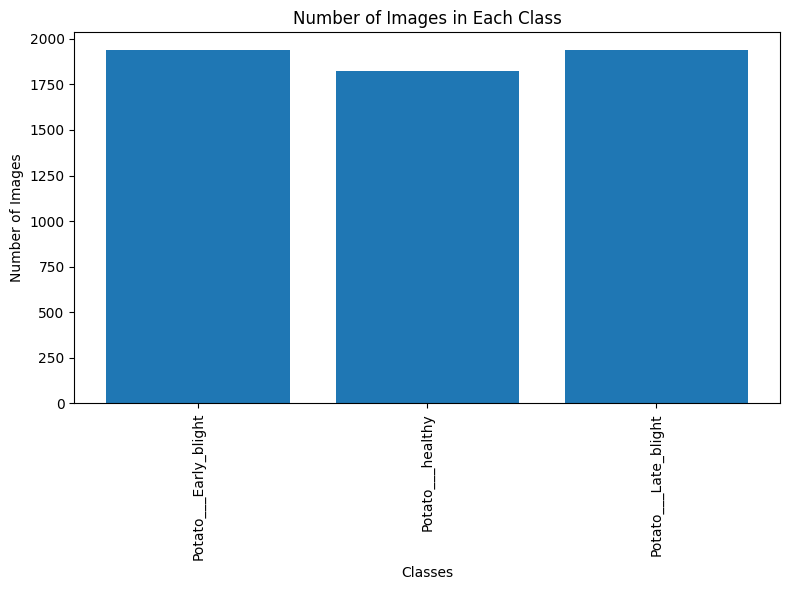

In [2]:
import os
import matplotlib.pyplot as plt

class_counts = {}

for category in categories:
    class_path = os.path.join(data_path, category)
    num_images = len(os.listdir(class_path))
    class_counts[category] = num_images

plt.figure(figsize=(8, 6))  # Increase the figure width
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of Images in Each Class')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)  # Increase rotation angle for better alignment
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Resizing and converting images into greyscale

In [3]:
from tqdm import tqdm

img_size = 224
data = []
label = []

# Wrap the outer loop with tqdm for progress tracking
for category in tqdm(categories, desc="Processing categories"):
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (img_size, img_size))
            # resizing the image into 224x224, as required by ResNet50
            data.append(resized)
            label.append(label_dict[category])
            # appending the image and the label(categorized) into the list (dataset)
        except Exception as e:
            print('Exception:', e)
            # if any exception raised, the exception will be printed here. And pass to the next image

Processing categories: 100%|█████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.87s/it]


In [4]:
data = np.array(data) / 255.0
data = np.stack((data,) * 3, axis=-1)  # stack grayscale images to create 3 channels
label = np.array(label)
new_label = to_categorical(label)

In [5]:
data.shape

(5702, 224, 224, 3)

## Splitting dataset into testing and training

In [6]:
x_train, x_test, y_train, y_test = train_test_split(data, new_label, test_size=0.2, random_state=42)

## VGG16

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16

img_size = 224

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers in the base VGG16 model
for layer in base_model.layers:
    layer.trainable = False

# Create the model architecture
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(len(categories), activation='softmax')(x)

# Define the input and output of the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# Define a function to schedule the learning rate
def lr_schedule(epoch):
    """
    Returns a custom learning rate that decreases as the epochs progress.
    """
    learning_rate = 0.001  # Initial learning rate
    
    if epoch > 5:
        learning_rate *= 0.1  # Decrease learning rate after 5 epochs
    if epoch > 10:
        learning_rate *= 0.1  # Further decrease after 10 epochs
    
    return learning_rate

# Define learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)
    
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Define model checkpoint callback to save the best model during training
checkpoint = ModelCheckpoint("../models/potato.keras", monitor='val_loss', save_best_only=True)

# Train the model with early stopping and model checkpoint callbacks
history_vgg = model.fit(x_train, y_train, 
                        batch_size=32, 
                        epochs=15, 
                        validation_data=(x_val, y_val),
                        callbacks=[lr_scheduler, early_stopping, checkpoint])

Epoch 1/15
114/114 [==============================] - 44s 204ms/step - loss: 0.6421 - accuracy: 0.7399 - val_loss: 0.3020 - val_accuracy: 0.8773 - lr: 0.0010
Epoch 2/15
114/114 [==============================] - 20s 172ms/step - loss: 0.2746 - accuracy: 0.8983 - val_loss: 0.1799 - val_accuracy: 0.9463 - lr: 0.0010
Epoch 3/15
114/114 [==============================] - 19s 171ms/step - loss: 0.1887 - accuracy: 0.9345 - val_loss: 0.1656 - val_accuracy: 0.9409 - lr: 0.0010
Epoch 4/15
114/114 [==============================] - 19s 170ms/step - loss: 0.1485 - accuracy: 0.9465 - val_loss: 0.1565 - val_accuracy: 0.9540 - lr: 0.0010
Epoch 5/15
114/114 [==============================] - 19s 171ms/step - loss: 0.1208 - accuracy: 0.9556 - val_loss: 0.1324 - val_accuracy: 0.9595 - lr: 0.0010
Epoch 6/15
114/114 [==============================] - 19s 170ms/step - loss: 0.0922 - accuracy: 0.9693 - val_loss: 0.1301 - val_accuracy: 0.9606 - lr: 0.0010
Epoch 7/15
114/114 [==============================] 

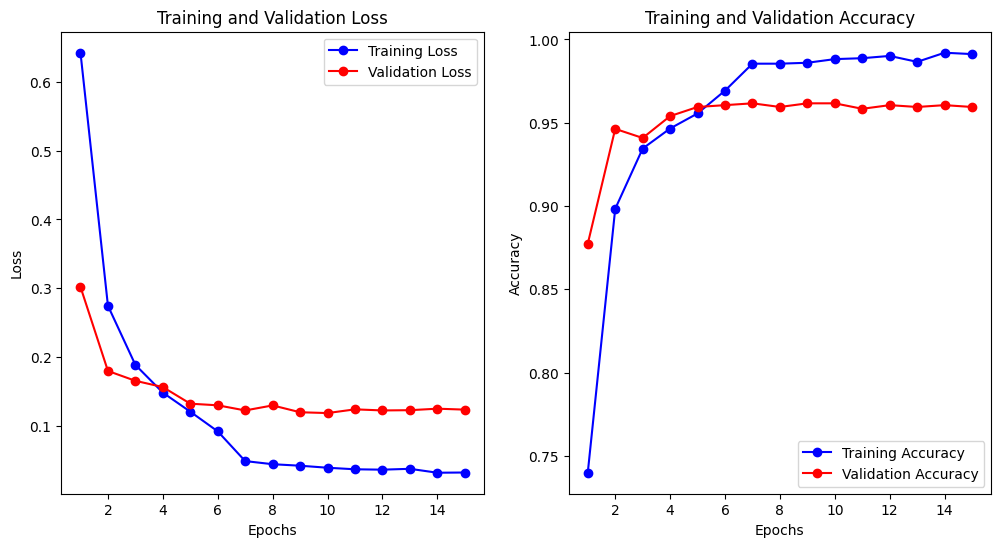

In [10]:
# Learning Curve
train_loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
train_accuracy = history_vgg.history['accuracy']
val_accuracy = history_vgg.history['val_accuracy'] 
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()